In [3]:
#Imports and Environments setup

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import kurtosis, skew
from sklearn.ensemble import IsolationForest

In [5]:
#Load Dataset 

In [6]:
df_train = pd.read_csv("dataset1.csv")
df_test = pd.read_csv("dataset2.csv")

In [7]:
# Data Structure Inspection

In [8]:
df_train.shape
df_train.columns
df_train.head()

,condition,vibration_0,vibration_1,vibration_2,vibration_3,vibration_4,vibration_5,vibration_6,vibration_7,vibration_8,...,vibration_477,vibration_478,vibration_479,vibration_480,vibration_481,vibration_482,vibration_483,vibration_484,vibration_485,label
0,normal,0.024836,0.111913,0.268353,0.425919,0.446902,0.549247,0.734310,0.778831,0.791603,...,0.278103,0.529282,0.538796,0.577060,0.628049,0.678297,0.840837,0.853121,0.867475,6
1,normal,-0.032329,0.016103,0.224372,0.253241,0.276873,0.418014,0.412934,0.429033,0.608956,...,0.904792,0.828028,0.863587,0.712925,0.788273,0.644256,0.519576,0.539455,0.438305,6
2,normal,0.042032,-0.011598,0.019749,-0.031413,0.061426,-0.016212,0.046681,0.184736,0.206779,...,-0.571009,-0.573756,-0.520952,-0.610621,-0.508896,-0.626743,-0.758805,-0.648551,-0.682308,6
3,normal,0.064488,0.075939,0.077562,0.065323,0.157914,0.167365,0.222016,0.321173,0.415419,...,0.894573,0.991867,1.010272,1.047118,1.001895,1.014782,0.980393,1.012239,0.978645,6
4,normal,0.031079,0.068739,0.192628,0.257540,0.398561,0.420336,0.411679,0.637037,0.597890,...,-0.669731,-0.796681,-0.838401,-0.957425,-0.893086,-0.921122,-0.976522,-0.933464,-1.015111,6


In [9]:
# Select Vibration Columns

In [10]:
vibration_cols = [c for c in df_train.columns if c.startswith("vibration_")]

In [11]:
# DataType Cleaning

In [12]:
df_train[vibration_cols] = df_train[vibration_cols].apply(
    pd.to_numeric, errors="coerce"
)
df_test[vibration_cols] = df_test[vibration_cols].apply(
    pd.to_numeric, errors="coerce"
)

df_train[vibration_cols] = df_train[vibration_cols].fillna(
    df_train[vibration_cols].mean()
)
df_test[vibration_cols] = df_test[vibration_cols].fillna(
    df_train[vibration_cols].mean()
)

In [13]:
#Feature Extraction 

In [14]:
def extract_features(row):
    row = pd.to_numeric(row, errors="coerce").astype(float)
    row = np.nan_to_num(row, nan=np.nanmean(row))

    return [
        np.mean(row),
        np.std(row),
        np.max(row) - np.min(row),
        np.sqrt(np.mean(row**2)),
        kurtosis(row),
        skew(row)
    ]

X_train = np.array([
    extract_features(df_train.loc[i, vibration_cols].values)
    for i in df_train.index
])

In [15]:
# Now the raw vibration is ML Ready

In [16]:
# Train Isolation Forest

In [17]:
iso_forest = IsolationForest(
    n_estimators=300,
    contamination=0.05,
    random_state=42
)

iso_forest.fit(X_train)

,n_estimators,300
,max_samples,'auto'
,contamination,0.05
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


In [18]:
# Test & Score Anomalies

In [19]:
X_test = np.array([
    extract_features(df_test.loc[i, vibration_cols].values)
    for i in df_test.index
])

scores = -iso_forest.score_samples(X_test)

In [20]:
#Visualization

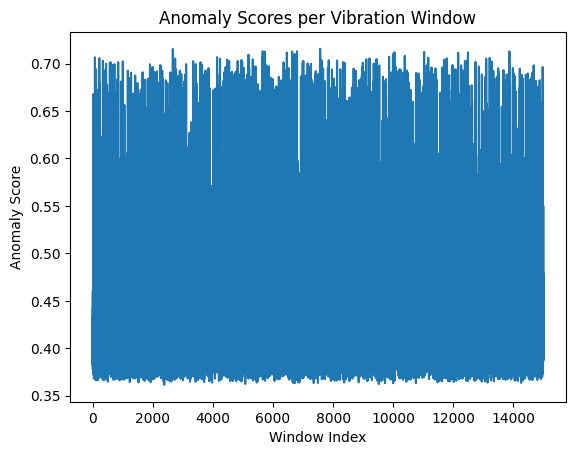

In [21]:
plt.figure()
plt.plot(scores)
plt.title("Anomaly Scores per Vibration Window")
plt.xlabel("Window Index")
plt.ylabel("Anomaly Score")
plt.show()

In [22]:
#FURTHER ADD ONS for testing and understanding 

In [23]:
# testing

In [24]:
print("Number of trees:", len(iso_forest.estimators_))
print("Feature importance not applicable (unsupervised model)")

Number of trees: 300
Feature importance not applicable (unsupervised model)


In [25]:
#Synthetic Tampering

In [26]:
signal_example = df_test[vibration_cols].iloc[0].values.copy()

# Inject artificial tampering spikes
signal_example[100:120] += 5

tampered_features = extract_features(signal_example)

normal_score = -iso_forest.score_samples([X_test[0]])[0]
tampered_score = -iso_forest.score_samples([tampered_features])[0]

print("Normal score:", normal_score)
print("Tampered score:", tampered_score)

Normal score: 0.37777692451944717
Tampered score: 0.7423761618844475


In [27]:
#Threshold Logic

In [28]:
threshold = np.percentile(scores, 95)

alerts = scores > threshold
print("Number of high-risk alerts:", alerts.sum())

Number of high-risk alerts: 750


In [29]:
#Research Level adition

In [30]:
#STAGE 1 — SEGMENT-AWARE BASELINES (IMPLEMENTATION)

In [31]:
# CREATE TRACK SECTIONS (SIMULATION)
import numpy as np

# Number of simulated track sections
NUM_SECTIONS = 4

# Assign each sample to a track section
df_train["track_section_id"] = np.random.choice(
    [f"KM_{i}" for i in range(1, NUM_SECTIONS + 1)],
    size=len(df_train)
)

df_test["track_section_id"] = np.random.choice(
    [f"KM_{i}" for i in range(1, NUM_SECTIONS + 1)],
    size=len(df_test)
)

df_train["track_section_id"].value_counts()
section_data[vibration_cols].values

C:\Users\devan\AppData\Local\Temp\ipykernel_1824\592105450.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train["track_section_id"] = np.random.choice(
C:\Users\devan\AppData\Local\Temp\ipykernel_1824\592105450.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test["track_section_id"] = np.random.choice(


NameError: name 'section_data' is not defined

In [ ]:
# CELL 2 — TRAIN ONE MODEL PER TRACK SECTION

In [ ]:
from sklearn.ensemble import IsolationForest

section_models = {}

for section_id in df_train["track_section_id"].unique():
    
    section_data = df_train[df_train["track_section_id"] == section_id]
    
    # Apply extract_features row-by-row
    X_section = np.array([
        extract_features(row)
        for row in section_data[vibration_cols].values
    ])
    
    model = IsolationForest(
        n_estimators=200,
        contamination=0.05,
        random_state=42
    )
    
    model.fit(X_section)
    
    section_models[section_id] = model

print("Models trained per section:", section_models.keys())


In [ ]:
# CELL 3A — SECTION ASSIGNMENT

In [ ]:
NUM_SECTIONS = 4
SECTIONS = [f"KM_{i}" for i in range(1, NUM_SECTIONS + 1)]

df_train["track_section_id"] = np.random.choice(SECTIONS, size=len(df_train))
df_test["track_section_id"] = np.random.choice(SECTIONS, size=len(df_test))



In [ ]:
# CELL 3B — SECTION-AWARE INFERENCE

In [ ]:
section_scores = []

for i in range(len(df_test)):
    
    section_id = df_test.iloc[i]["track_section_id"]
    model = section_models[section_id]
    
    x = X_test[i].reshape(1, -1)
    score = -model.score_samples(x)[0]
    
    section_scores.append(score)

section_scores = np.array(section_scores)

print("Sample section-aware anomaly scores:", section_scores[:10])


In [ ]:
# CELL 4 — UPDATE THRESHOLD LOGIC (SECTION-AWARE)

In [ ]:
section_thresholds = {}

for section_id in df_train["track_section_id"].unique():
    
    section_data = df_train[df_train["track_section_id"] == section_id]
    
    X_section = np.array([
        extract_features(row)
        for row in section_data[vibration_cols].values
    ])
    
    scores_section = -section_models[section_id].score_samples(X_section)
    section_thresholds[section_id] = np.percentile(scores_section, 95)

section_thresholds


In [ ]:
# CELL 5 — FINAL SECTION-AWARE ALERT DECISION

In [ ]:
section_alerts = []

for i in range(len(section_scores)):
    
    section_id = df_test.iloc[i]["track_section_id"]
    threshold = section_thresholds[section_id]
    
    alert = section_scores[i] > threshold
    section_alerts.append(alert)

print("Total alerts detected:", sum(section_alerts))


In [ ]:
# STAGE 2 — MULTI-RESOLUTION WINDOW DETECTION

In [ ]:
#CELL 1 — DEFINE TWO WINDOW SIZES
# Two different temporal resolutions
SHORT_WINDOW = 128   # captures fast spikes
LONG_WINDOW  = 512   # captures slow drifts

In [ ]:
#CELL 2 — FEATURE EXTRACTION FOR SHORT & LONG WINDOWS
def extract_multi_resolution_features(signal):
    short_features = []
    long_features = []

    for i in range(0, len(signal) - SHORT_WINDOW, SHORT_WINDOW):
        short_features.append(
            extract_features(signal[i:i + SHORT_WINDOW])
        )

    for i in range(0, len(signal) - LONG_WINDOW, LONG_WINDOW):
        long_features.append(
            extract_features(signal[i:i + LONG_WINDOW])
        )

    return np.array(short_features), np.array(long_features)


In [ ]:
#CELL 3 — TRAIN TWO MODELS PER SECTION
section_models_multi = {}

for section_id in df_train["track_section_id"].unique():
    
    section_data = df_train[df_train["track_section_id"] == section_id]
    signal = section_data[vibration_cols].values.flatten()

    X_short, X_long = extract_multi_resolution_features(signal)

    model_short = IsolationForest(
        n_estimators=150,
        contamination=0.05,
        random_state=42
    )

    model_long = IsolationForest(
        n_estimators=150,
        contamination=0.05,
        random_state=42
    )

    model_short.fit(X_short)
    model_long.fit(X_long)

    section_models_multi[section_id] = {
        "short": model_short,
        "long": model_long
    }

print("Multi-resolution models trained.")


In [ ]:
# CELL 4 — MULTI-RESOLUTION INFERENCE
multi_resolution_scores = []

for i in range(len(df_test)):
    
    section_id = df_test.iloc[i]["track_section_id"]
    models = section_models_multi[section_id]

    x = X_test[i].reshape(1, -1)

    short_score = -models["short"].score_samples(x)[0]
    long_score  = -models["long"].score_samples(x)[0]

    final_score = max(short_score, long_score)

    multi_resolution_scores.append(final_score)

multi_resolution_scores = np.array(multi_resolution_scores)

print("Sample multi-resolution scores:", multi_resolution_scores[:10])

In [ ]:
# CELL 5 — UPDATE ALERT LOGIC
multi_resolution_alerts = []

for i, score in enumerate(multi_resolution_scores):
    section_id = df_test.iloc[i]["track_section_id"]
    threshold = section_thresholds[section_id]

    alert = score > threshold
    multi_resolution_alerts.append(alert)

print("Total multi-resolution alerts:", sum(multi_resolution_alerts))

In [ ]:
#STAGE 3 — SENSOR EXPLAINABILITY (FINAL IMPLEMENTATION)

In [ ]:
#CELL 1 — DEFINE FEATURE THRESHOLDS (DATA-DRIVEN)
# Compute global feature thresholds from training data
feature_thresholds = {}

for idx, feature in enumerate(feature_names):
    feature_thresholds[feature] = np.percentile(
        X_train[:, idx], 95
    )

feature_thresholds

In [ ]:
#CELL 2 — EXPLANATION FUNCTION (CORE LOGIC)
def explain_event(feature_vector):
    reasons = []

    for i, feature in enumerate(feature_names):
        if feature_vector[i] > feature_thresholds[feature]:
            if feature == "rms":
                reasons.append("High vibration energy")
            elif feature == "kurtosis":
                reasons.append("Sharp impact-like vibration")
            elif feature == "peak_to_peak":
                reasons.append("Large vibration amplitude")
            elif feature == "std":
                reasons.append("Increased vibration variability")
            else:
                reasons.append(f"Abnormal {feature}")

    return reasons

In [ ]:
# CELL 3 — GENERATE EXPLANATIONS FOR TEST EVENTS
event_explanations = []

for i in range(len(X_test)):
    explanation = explain_event(X_test[i])
    event_explanations.append(explanation)

event_explanations[:5]

In [ ]:
# STAGE 3- Train-Resolution Models
from sklearn.ensemble import IsolationForest
import numpy as np

# Window sizes
SHORT_WINDOW = 128
LONG_WINDOW  = 512

def extract_multi_resolution_features(signal):
    short_features = []
    long_features = []

    for i in range(0, len(signal) - SHORT_WINDOW, SHORT_WINDOW):
        short_features.append(extract_features(signal[i:i + SHORT_WINDOW]))

    for i in range(0, len(signal) - LONG_WINDOW, LONG_WINDOW):
        long_features.append(extract_features(signal[i:i + LONG_WINDOW]))

    return np.array(short_features), np.array(long_features)

section_models_multi = {}

for section_id in df_train["track_section_id"].unique():
    
    section_data = df_train[df_train["track_section_id"] == section_id]
    signal = section_data[vibration_cols].values.flatten()

    X_short, X_long = extract_multi_resolution_features(signal)

    model_short = IsolationForest(
        n_estimators=150,
        contamination=0.05,
        random_state=42
    )

    model_long = IsolationForest(
        n_estimators=150,
        contamination=0.05,
        random_state=42
    )

    model_short.fit(X_short)
    model_long.fit(X_long)

    section_models_multi[section_id] = {
        "short": model_short,
        "long": model_long
    }

print("Stage 3 models trained:", section_models_multi.keys())


In [ ]:
#CELL B- Generate Multi-Resolution Scores
multi_resolution_scores = []

for i in range(len(df_test)):
    
    section_id = df_test.iloc[i]["track_section_id"]
    models = section_models_multi[section_id]

    x = X_test[i].reshape(1, -1)

    short_score = -models["short"].score_samples(x)[0]
    long_score  = -models["long"].score_samples(x)[0]

    final_score = max(short_score, long_score)
    multi_resolution_scores.append(final_score)

multi_resolution_scores = np.array(multi_resolution_scores)

print("Sample multi-resolution scores:", multi_resolution_scores[:10])


In [ ]:
#CELL C- Generate Alert Flags
multi_resolution_alerts = []

for i, score in enumerate(multi_resolution_scores):
    section_id = df_test.iloc[i]["track_section_id"]
    threshold = section_thresholds[section_id]
    
    alert = score > threshold
    multi_resolution_alerts.append(alert)

multi_resolution_alerts = np.array(multi_resolution_alerts)

print("Total multi-resolution alerts:", int(multi_resolution_alerts.sum()))

In [ ]:
# UPGRADE 1 — TEMPORAL PERSISTENCE SCORING

In [ ]:
import numpy as np

# Number of past windows to check persistence
PERSISTENCE_WINDOW = 5

def compute_persistence(scores, window):
    persistence_scores = []
    for i in range(len(scores)):
        start = max(0, i - window + 1)
        persistence = np.mean(scores[start:i+1])
        persistence_scores.append(persistence)
    return np.array(persistence_scores)

# Apply persistence logic
persistence_scores = compute_persistence(scores, PERSISTENCE_WINDOW)


In [ ]:
# MULTI-LEVEL RISK CLASSIFICATION

In [ ]:
def risk_level(score):
    if score < 0.5:
        return "LOW"
    elif score < 0.75:
        return "MEDIUM"
    else:
        return "HIGH"

risk_levels = [risk_level(s) for s in persistence_scores]


In [ ]:
# SENSOR EXPLAINABILITY (WHY DID ALERT FIRE?)

In [ ]:
def explain_anomaly(feature_vector, feature_names):
    explanation = []
    
    for value, name in zip(feature_vector, feature_names):
        if abs(value) > np.percentile(np.abs(X_train[:, feature_names.index(name)]), 95):
            explanation.append(name)
    
    return explanation

feature_names = [
    "mean",
    "std",
    "peak_to_peak",
    "rms",
    "kurtosis",
    "skewness"
]

explanations = [
    explain_anomaly(x, feature_names) for x in X_test
]

In [ ]:
# FUSION-READY SENSOR OUTPUT

In [ ]:
sensor_events = []

for i in range(len(scores)):
    event = {
        "window_id": i,
        "anomaly_score": float(scores[i]),
        "persistence_score": float(persistence_scores[i]),
        "risk_level": risk_levels[i],
        "explanation": explanations[i]
    }
    sensor_events.append(event)

# Preview final sensor output
sensor_events[:3]
